In [65]:
from pharynx_analysis import (
    pharynx_io as pio, image_processing as ip, 
    experiment, plots, profile_processing, data_analysis
)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale
import skimage
import logging
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import seaborn as sns
from skfda import FDataGrid
import skfda
from statsmodels.stats.weightstats import DescrStatsW
from scipy import signal
import matlab.engine
import matlab
import pandas as pd
from pathlib import Path
import matplotlib
from tqdm import tqdm_notebook
import matlab.engine

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(data_analysis)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [5]:
experiment_dir = "/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47"
imaging_scheme = "TL/470/410/470/410"

10:04:38 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47
10:04:38 INFO:Loading Images
10:04:38 INFO:Segmenting pharynxes
10:04:40 INFO:Centering and rotating pharynxes
100%|██████████| 123/123 [00:09<00:00, 13.45it/s]
10:04:50 INFO:Calculating midlines
100%|██████████| 123/123 [00:01<00:00, 106.35it/s]
10:04:51 INFO:Measuring under midlines
100%|██████████| 123/123 [00:01<00:00, 103.64it/s]
10:04:52 INFO:Trimming intensity data
10:04:53 INFO:Calculating redox measurements
10:04:53 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47
10:04:53 INFO:Saving region means to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-08-26_new_reg/2017_02_22-HD233_SAY47-summary_table.csv
10:04:54 INFO:Saving profile data to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-08-26_new_reg/2017_02_22-HD233_SAY47-profil

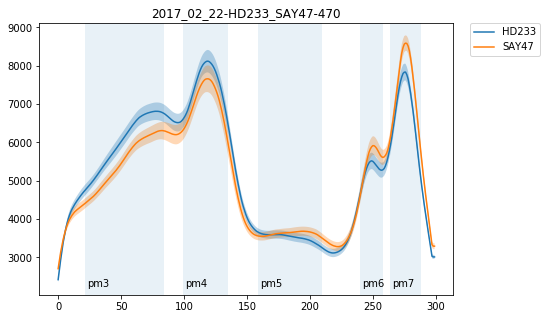

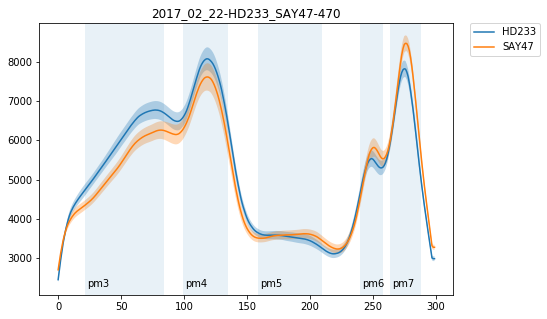

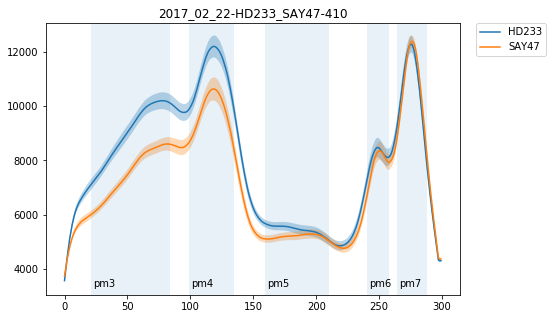

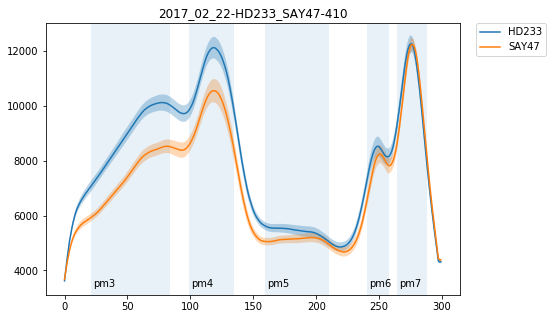

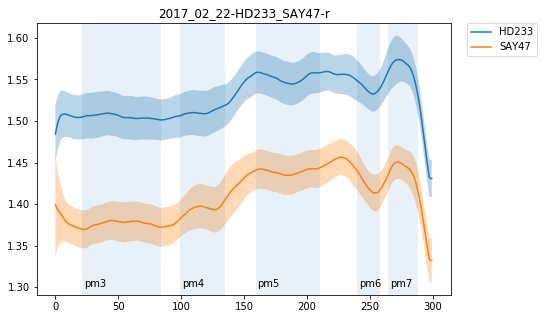

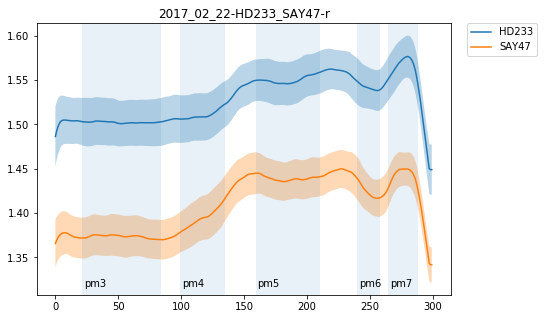

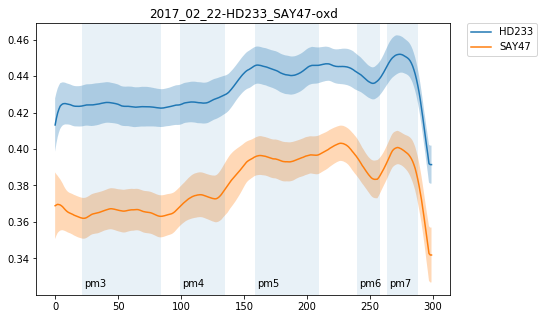

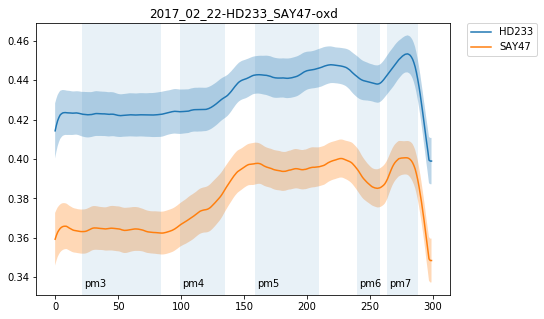

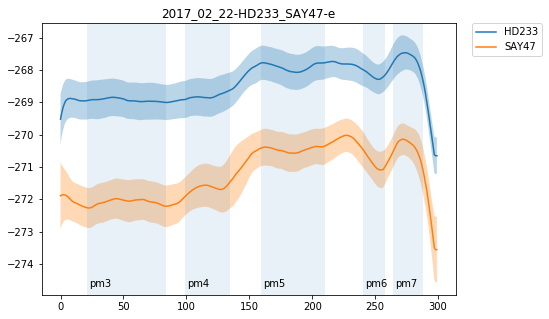

<Figure size 720x360 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

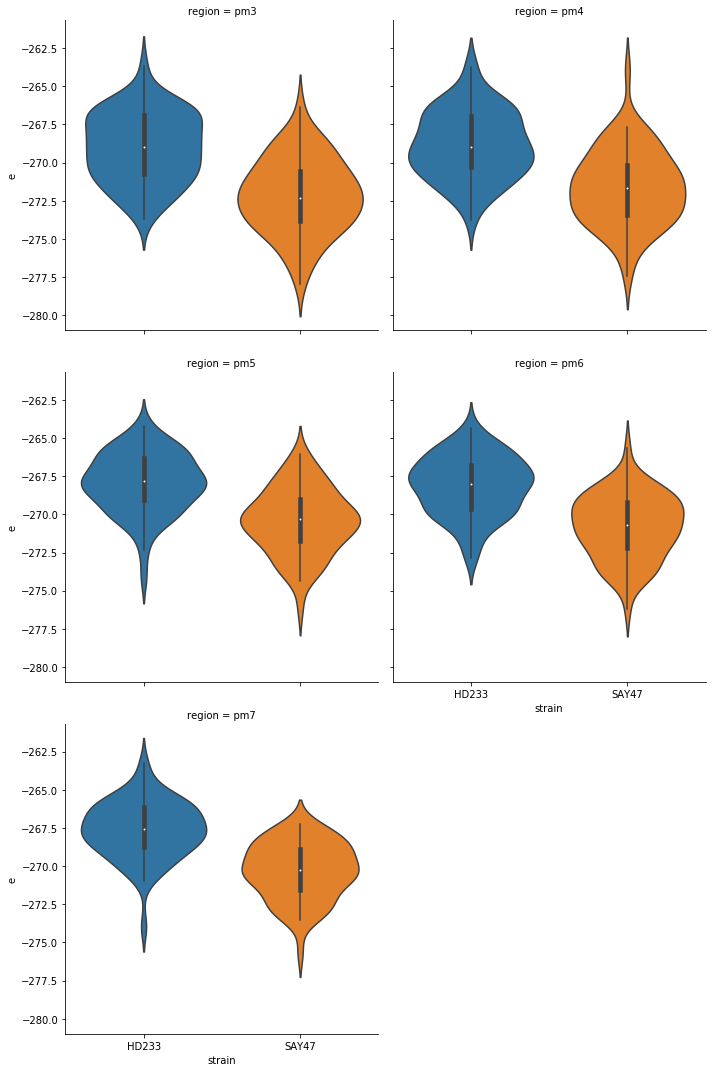

In [61]:
ex_unreg = experiment.PairExperiment(
    experiment_dir=experiment_dir,
    imaging_scheme=imaging_scheme,
    trim_threshold=4000,
    save_summary_plots=True,
    temperature=22.0,
    r_min=0.852,
    r_max=6.65,
    strategy='new_reg',
    should_register=False
)
ex_unreg.full_pipeline()

In [64]:
ex_unreg.untrimmed_profiles.position.size

200

10:05:48 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47
10:05:48 INFO:Loading Images
10:05:49 INFO:Segmenting pharynxes
10:05:50 INFO:Centering and rotating pharynxes
100%|██████████| 123/123 [00:08<00:00, 14.54it/s]
10:05:59 INFO:Calculating midlines
100%|██████████| 123/123 [00:01<00:00, 119.91it/s]
10:06:00 INFO:Measuring under midlines
100%|██████████| 123/123 [00:00<00:00, 128.65it/s]
10:06:01 INFO:Registering profiles
10:07:25 INFO:Trimming intensity data
10:07:26 INFO:Calculating redox measurements
10:07:26 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47
10:07:26 INFO:Saving region means to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-08-26_new_reg/2017_02_22-HD233_SAY47-summary_table.csv
10:07:27 INFO:Saving profile data to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-08-26_ne

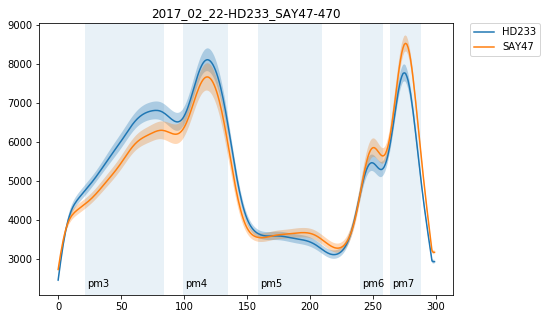

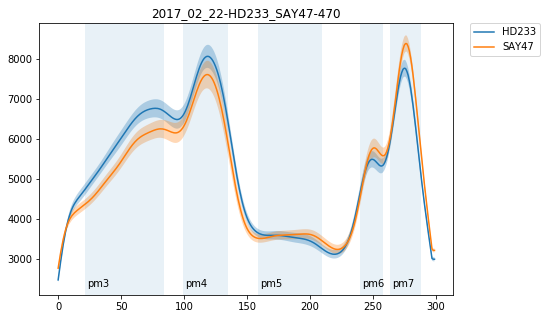

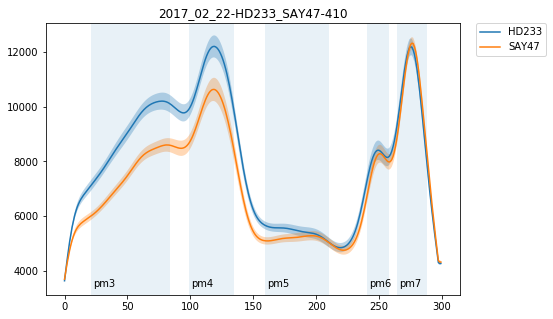

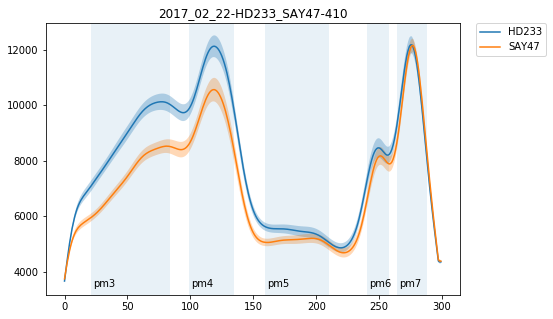

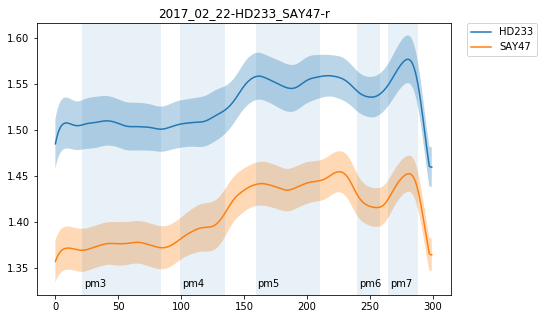

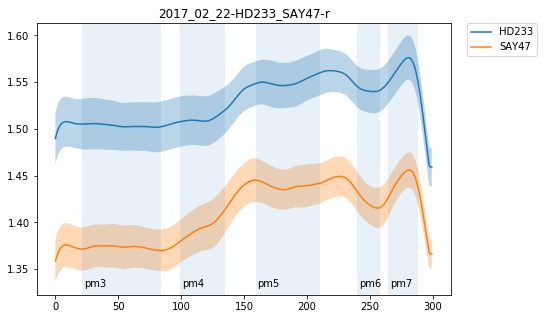

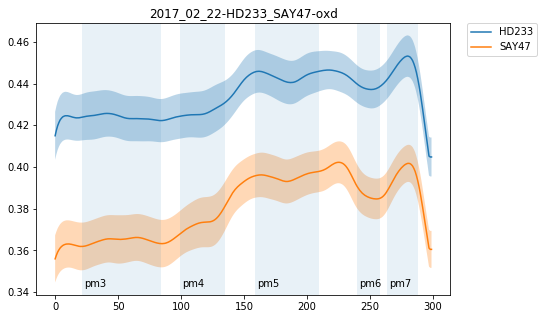

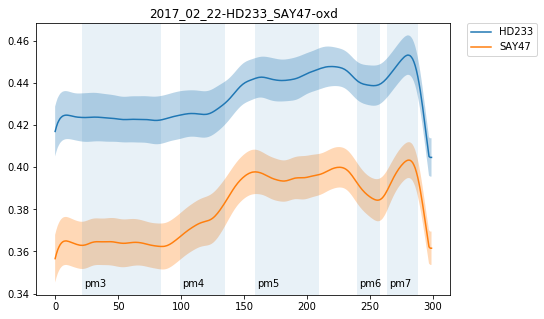

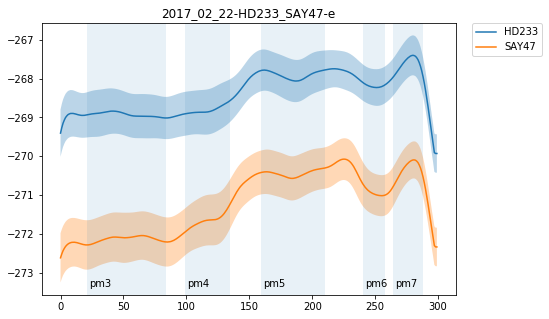

<Figure size 720x360 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

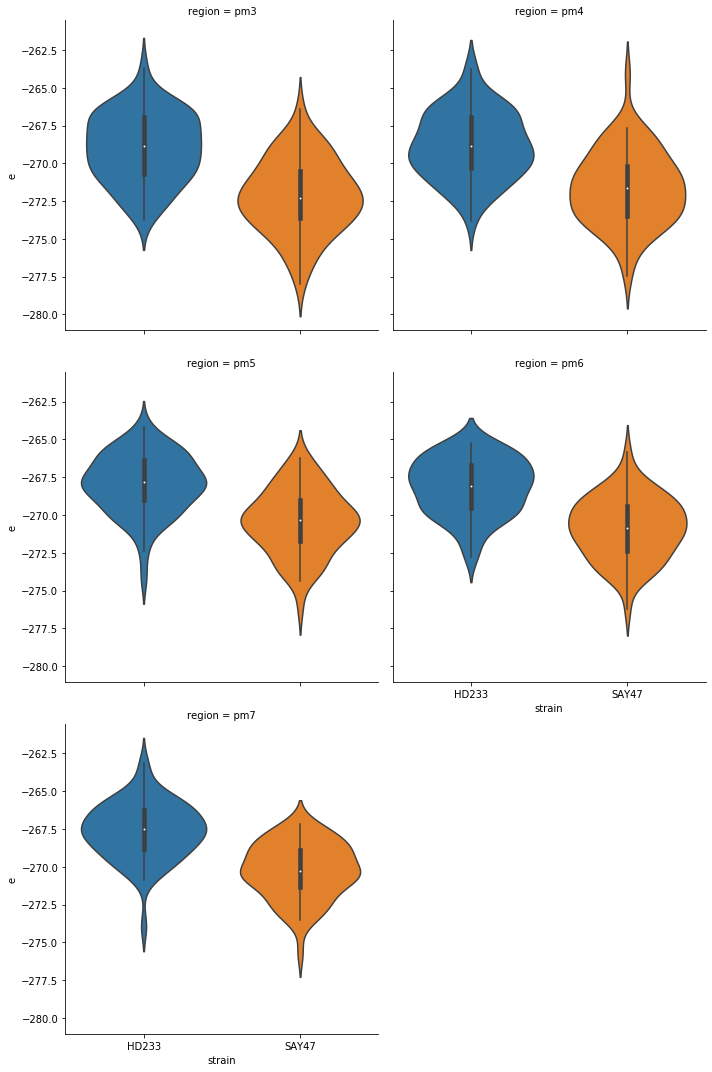

In [66]:
ex_reg = experiment.PairExperiment(
    experiment_dir=experiment_dir,
    imaging_scheme=imaging_scheme,
    trim_threshold=4000,
    save_summary_plots=True,
    temperature=22.0,
    r_min=0.852,
    r_max=6.65,
    strategy='new_reg',
    should_register=True
)
ex_reg.full_pipeline()

In [67]:
ex_reg.r

AttributeError: 'PairExperiment' object has no attribute 'r'

# Interfacing with MATLAB

In [7]:
eng = matlab.engine.connect_matlab('worm')

In [23]:
i410 = ex_unreg.untrimmed_profiles.sel(pair=0, wavelength='410').values.T
i470 = ex_unreg.untrimmed_profiles.sel(pair=0, wavelength='470').values.T

data410 = matlab.double(i410.tolist())
data470 = matlab.double(i470.tolist())

In [24]:
eng.workspace['data410'] = data410

In [25]:
rdata = eng.smoothRoughRegisterDiscretize(data410, data470, 2, .316, 100, nargout=2)

In [26]:
r410, r470 = rdata

np.array(r470).shape

(100, 123)

In [31]:
i410.shape

(200, 123)

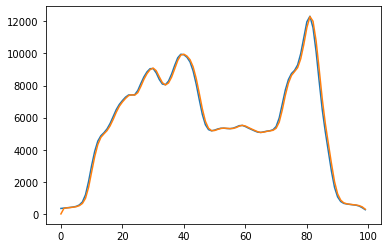

In [52]:
from scipy.ndimage.interpolation import shift

r410 = np.array(r410)
plt.plot(r410[:,1])
plt.plot(shift(r410[:,1], .4))

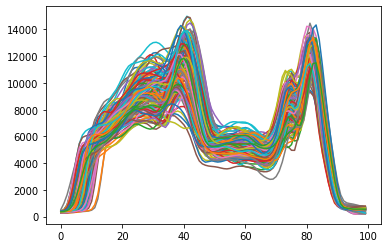

In [143]:
plt.plot(np.array(eng.workspace['i1_reg']._data).reshape(123,100).T);

# Diagnostic Plots

In [6]:
def scale_by_wvl(data: xr.DataArray) -> xr.DataArray:
    scaled = data.copy()
    for wvl in scaled.wavelength:
        for pair in scaled.pair:
            unscaled = scaled.sel(wavelength=wvl, pair=pair).values
            scaled.loc[dict(wavelength=wvl, pair=pair)]= scale(unscaled, axis=1)
    return scaled

In [7]:
sc_raw = scale_by_wvl(ex.untrimmed_profiles)
sc_reg = scale_by_wvl(ex_reg.untrimmed_profiles)

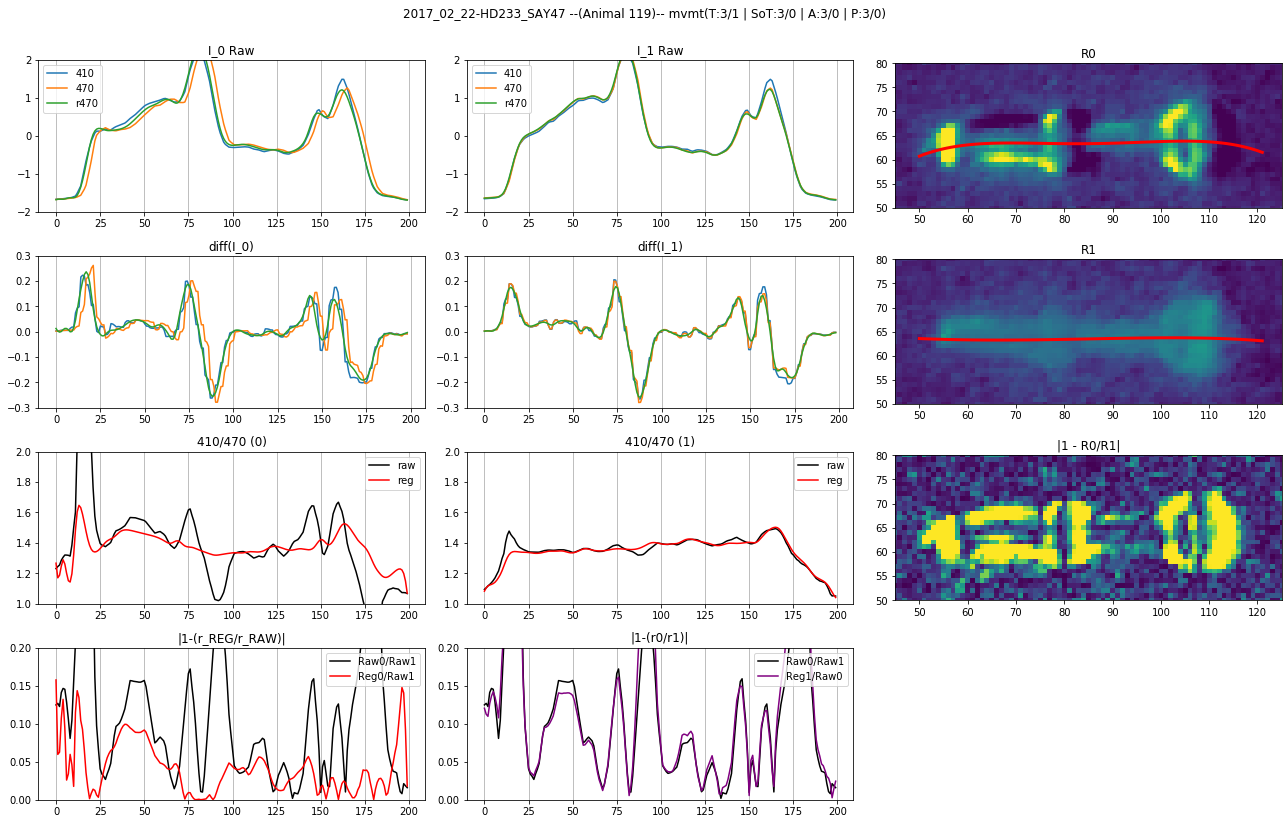

In [69]:
reload(plots);


plots.plot_reg_diagnostic(ex_unreg, ex_reg, 119);

In [225]:
output_filepath = '/Users/sean/Desktop/testing.pdf'
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages(output_filepath) as pdf:
    for i in tqdm_notebook(range(ex.strains.size)):
        f = diagnostic_plot(ex, ex_reg, i)
        pdf.savefig()
        plt.close(f)

03:50:29 DEBUG:Assigning font /b'F1' = '/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
03:52:59 DEBUG:Embedding font /Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
03:52:59 DEBUG:Writing TrueType font.
